# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(10):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)  # initialize the score (for each agent)
    tick = 0
    while True:
        tick += 1
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print(f'Tick {tick}')
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Tick 1001
Total score (averaged over agents) this episode: 0.13699999693781137
Tick 1001
Total score (averaged over agents) this episode: 0.0789999982342124
Tick 1001
Total score (averaged over agents) this episode: 0.09549999786540866
Tick 1001
Total score (averaged over agents) this episode: 0.07849999824538827
Tick 1001
Total score (averaged over agents) this episode: 0.1579999964684248
Tick 1001
Total score (averaged over agents) this episode: 0.12649999717250465
Tick 1001
Total score (averaged over agents) this episode: 0.13449999699369072
Tick 1001
Total score (averaged over agents) this episode: 0.16449999632313847
Tick 1001
Total score (averaged over agents) this episode: 0.20199999548494815
Tick 1001
Total score (averaged over agents) this episode: 0.06449999855831265


## PPO Solution part1: Neural Network Model

In the network model part , we use 2 networks : actor network and critic network.

### Actor network use state to predict action.


network architecture:

- Actor(
  - (fc1): Linear(in_features=33, out_features=512, bias=True)
  - (fc2): Linear(in_features=512, out_features=256, bias=True)
  - (fc3): Linear(in_features=256, out_features=4, bias=True)
- )

### Critic network use state to predict value(expectation of discounted return of future).

network architecture:

- Critic(
  - (fcs1): Linear(in_features=33, out_features=512, bias=True)
  - (fc2): Linear(in_features=512, out_features=256, bias=True)
  - (fc3): Linear(in_features=256, out_features=1, bias=True)
- )

### Policy network to synthesis information in actor network and critic network.

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Policy(nn.Module):
    """(Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=512 , fc2_units = 256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Policy, self).__init__()
        print("network state size: " , state_size)
        print("network action size: " , action_size)
        self.actor = Actor(state_size , action_size , seed,fc1_units , fc2_units)
        self.critic = Critic(state_size , action_size , seed , fc1_units , fc2_units)
        self.std = torch.Tensor(nn.Parameter(torch.ones(1, action_size)))

        
    
    def forward(self, state, action = None):
        """Build an actor (policy) network that maps states -> actions."""
        
        
        phi_a = self.actor(state)
        phi_v = self.critic(state)
        
        dist = torch.distributions.Normal(phi_a, self.std)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action).sum(-1).unsqueeze(-1)
        entropy = dist.entropy()
        
        return {'a': action,
                'log_pi_a': log_prob,
                'ent': entropy,
                'mean': phi_a,
                'v': phi_v}
        
class Actor(nn.Module):
    def __init__(self, state_size , action_size , seed, fc1_units , fc2_units):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3,3e-3)
    
    def forward(self,state):
        xs = F.relu(self.fc1(state))
        x = F.relu(self.fc2(xs))
        action = F.tanh(self.fc3(x))
        return action

class Critic(nn.Module):
    def __init__(self, state_size , action_size , seed , fc1_units , fc2_units):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self,state):
        xs = F.relu(self.fc1(state))
        x = F.relu(self.fc2(xs))
        value = self.fc3(x)
        return value

## PPO Solution part2: PPO agent

In the agent part , we process data and train agent to get higher score in every episode. We divide every step into three parts: collect trajectories , compute advantages and training.

### Collect trajectories


First we reset the environment , use latest policy to compute action , gaussian probability and value.
then we use action to get next state , reward and done information.
We collect every step's information into list at last.


### Compute advantages

In this part, we use GAE(generalized advantage function) as advantage function. In every time step , the gae equals td error plus gae tau multiply next time step's advantage function.


### Training

We use stochastic gradient descent to train the networks.
To avoid "cliff" in training process , we use clip function to control the value of loss.


### Hyperparameters

- SGD_epochs : 4 
- SGD_batch_size : 64 
- discount rate: 0.99
- ratio clip(clip function parameter): 0.1
- ratio clip decay rate(ratio clip parameter decay after every episode): 0.999
- GAE tau: 0.95
- gradient clip parameter: 5

In [6]:
# from ppo_model import Policy
from collections import deque

class Config:
    optimizer_fn = lambda params: torch.optim.Adam(params, 1e-4, eps=1e-5)
    optimization_epochs = 4
    network = lambda state_size , action_size: Policy(state_size , action_size)
    discount = 0.99
    ratio_clip = 0.1
    batch_size = 64
    entropy_weight = 0.01
    max_episode = 500
    gradient_clip = 5
    use_gae = True
    gae_tau = 0.95


def random_sample(indices, batch_size):
        indices = np.asarray(np.random.permutation(indices))
        batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
        for batch in batches:
            yield batch
        r = len(indices) % batch_size
        if r:
            yield indices[-r:]
        
def to_tt(np_array):
    return torch.tensor(np_array , dtype = torch.float , device=device)
        
class PPOAgent(object):
    def __init__(self, env):
        
        self.env = env
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(self.env_info.agents)
        print('Number of agents:', self.num_agents)
        self.action_size = self.brain.vector_action_space_size
        print('Size of each action:', self.action_size)
        self.states = self.env_info.vector_observations
        self.state_size = self.states.shape[1]
        print('There are {} agents. Each observes a state with length: {}'.format(self.states.shape[0], self.state_size))
        
        self.network = Config.network(self.state_size , self.action_size)
        
        self.opt = Config.optimizer_fn(self.network.parameters())
        
        self.total_steps = 0
        
        
        self.score = None
        self.score_window = deque(maxlen = 100)
        self.score_list = []
    
    def collect_trajectories_vec(self):
        
        state_list=[]
        reward_list=[]
        prob_list=[]
        action_list=[]
        dones_list=[]
        values_list = []

        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        
        states = self.env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(self.num_agents)                          # initialize the score (for each agent)
        
        while True:
            ### Important note: Don't add next_state to state_list!!!
            state_list.append(states)
            
            probs = []
            values = []
            states = torch.tensor(states ,dtype = torch.float ,device = device)
            prediction = self.network(states)
            
            self.network.eval()
            with torch.no_grad():
                action = prediction['a'].squeeze().cpu().detach().numpy()
                prob = prediction['log_pi_a'].squeeze(-1).cpu().detach().numpy()
                value = prediction['v'].squeeze(-1).cpu().detach().numpy()
            self.network.train()
            
            self.env_info = self.env.step(action)[brain_name]           # send all actions to tne environment
            next_states = self.env_info.vector_observations         # get next state (for each agent)
            rewards = self.env_info.rewards                         # get reward (for each agent)
            dones = self.env_info.local_done                        # see if episode finished
            scores += self.env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            
            
            reward_list.append(rewards)
            dones_list.append(dones)
            
            action_list.append(action)
            prob_list.append(prob)
            values_list.append(value)
        
            if np.any(dones):                                  # exit loop if episode finished
                break
#         print("scores: " , scores)
#         print("mean score: " , np.mean(scores))
        
        self.score = np.mean(scores)
        self.score_window.append(self.score)
        self.score_list.append(self.score)
        return state_list, reward_list , action_list, prob_list, dones_list, values_list

    
    
    
    def compute_advantage(self,r,d,v):
        length = len(v)
        
        ## The order in advantages_list should be keeped!!
        advantages_list = [None]*length
        advantages = to_tt(np.zeros(self.num_agents))
        returns = to_tt(np.zeros(self.num_agents))
        for i in reversed(range(length)):
            done = np.array(d[i]).astype(int)
            done = to_tt(done)
            returns = to_tt(r[i])
            next_v = to_tt(v[min(length-1,i+1)])
            this_v = to_tt(v[i])
            td_error = returns + Config.discount * (1-done) * next_v.detach() - to_tt(v[i]).detach()
                
            if not Config.use_gae:
                advantages = td_error
            else:
                advantages = Config.gae_tau * Config.discount * advantages * (1-done) + td_error
            advantages_list[i] = advantages
        return advantages_list
        
    
    
    def mystep(self):
        #20个agent是分开训练还是一起训练？
        s,r,a,p,d,v = self.collect_trajectories_vec()
        s,r,a,p,d,v = to_tt(s),to_tt(r),to_tt(a).detach(),to_tt(p).detach(),to_tt(d),to_tt(v)
        
#         print("s0",s[0]) # 33*20
#         print("r0",r[0]) # 1*20
#         print("a0",a[0]) # 4*20
#         print("p0",p[0]) # 1*20
#         print("d0",d[0]) # 1*20
#         print("v0",v[0]) # 1*20
#         print("s-1",s[-1]) # 33*20
#         print("r-1",r[-1]) # 1*20
#         print("a-1",a[-1]) # 4*20
#         print("p-1",p[-1]) # 1*20
#         print("d-1",d[-1]) # 1*20
#         print("v-1",v[-1]) # 1*20
        
        
        for _ in range(Config.optimization_epochs):
            advantages = self.compute_advantage(r,d,v)

#             print("advantage0" , advantages[0])
#             print("advantage-1" , advantages[-1])

            advantages = torch.stack(advantages)# .squeeze(2)
            advantages = (advantages - advantages.mean()) / advantages.std()

        
            sampler = random_sample(np.arange(advantages.shape[0]) , Config.batch_size)
            for batch_indices in sampler:
                sampled_states = to_tt(s[batch_indices])
                sampled_action = to_tt(a[batch_indices])
                sampled_log_probs_old = to_tt(p[batch_indices])
                sampled_returns = to_tt(r[batch_indices])
                sampled_advantages = to_tt(advantages[batch_indices])
                prediction = self.network(sampled_states , sampled_action)
                ratio = (prediction['log_pi_a'].squeeze() - sampled_log_probs_old).exp()
                
                obj = ratio * sampled_advantages
                obj_clipped = ratio.clamp(1.0-Config.ratio_clip , 1.0+Config.ratio_clip) * sampled_advantages
                
                    
                policy_loss = -torch.min(obj , obj_clipped).mean() #- Config.entropy_weight * prediction['ent'].mean()
                value_loss = 0.5 * (sampled_returns - prediction['v'].squeeze()).pow(2).mean()

                self.opt.zero_grad()
                policy_loss.backward()
#                 (policy_loss + value_loss).backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), Config.gradient_clip)
                self.opt.step()

    def main(self):
#         !pip install progressbar
#         import progressbar as pb
#         widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
#         timer = pb.ProgressBar(widgets=widget, maxval=Config.max_episode).start()
        for e in range(Config.max_episode):
            Config.entropy_weight *= 0.995
            Config.ratio_clip *= 0.999
            self.mystep()
            
            msg = '\rEpisode {}\t Average Score: {:.2f}\t Score: {:.2f}'
            print(msg.format(e, np.mean(self.score_window), self.score), end="")
            if e % 10 == 0:
                print(msg.format(e, np.mean(self.score_window), self.score))
                
            if np.mean(self.score_window) >= 30.:
                print(f"Mission Complete!!!  in {e} Episode")
                break
#             timer.update(e+1)
#         timer.finish()
        
    
    

In [7]:
# from ppo_agent import PPOAgent
agent = PPOAgent(env)
agent.main()

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
network state size:  33
network action size:  4
Episode 0	 Average Score: 0.04	 Score: 0.04
Episode 10	 Average Score: 0.40	 Score: 0.86
Episode 20	 Average Score: 0.95	 Score: 1.74
Episode 30	 Average Score: 1.46	 Score: 2.73
Episode 40	 Average Score: 1.94	 Score: 4.34
Episode 50	 Average Score: 2.45	 Score: 5.00
Episode 60	 Average Score: 2.99	 Score: 6.20
Episode 70	 Average Score: 3.57	 Score: 7.49
Episode 80	 Average Score: 4.20	 Score: 8.90
Episode 90	 Average Score: 4.80	 Score: 10.76
Episode 100	 Average Score: 5.54	 Score: 11.69
Episode 110	 Average Score: 6.91	 Score: 16.10
Episode 120	 Average Score: 8.47	 Score: 19.30
Episode 130	 Average Score: 10.15	 Score: 21.90
Episode 140	 Average Score: 12.06	 Score: 26.03
Episode 150	 Average Score: 14.14	 Score: 25.17
Episode 160	 Average Score: 16.29	 Score: 28.66
Episode 170	 Average Score: 18.49	 Score: 28.88
Episode 180	 Avera

## Training Result

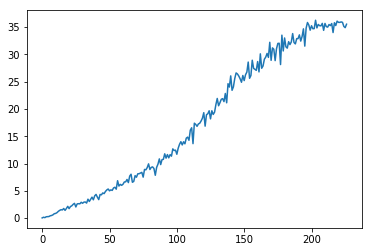

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(agent.score_list)

## Save Model Weight

In [10]:
torch.save(agent.network.actor.state_dict(), 'actor.pth')
torch.save(agent.network.critic.state_dict(), 'critic.pth')
